In [2]:
# Please install the following 
# %pip install geopandas folium scikit-learn


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp8x5ee4t0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp8x5ee4t0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=2/part-00060-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2630-2.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp8x5ee4t0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=3/part-00196-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2766-1.c000.snappy.parquet


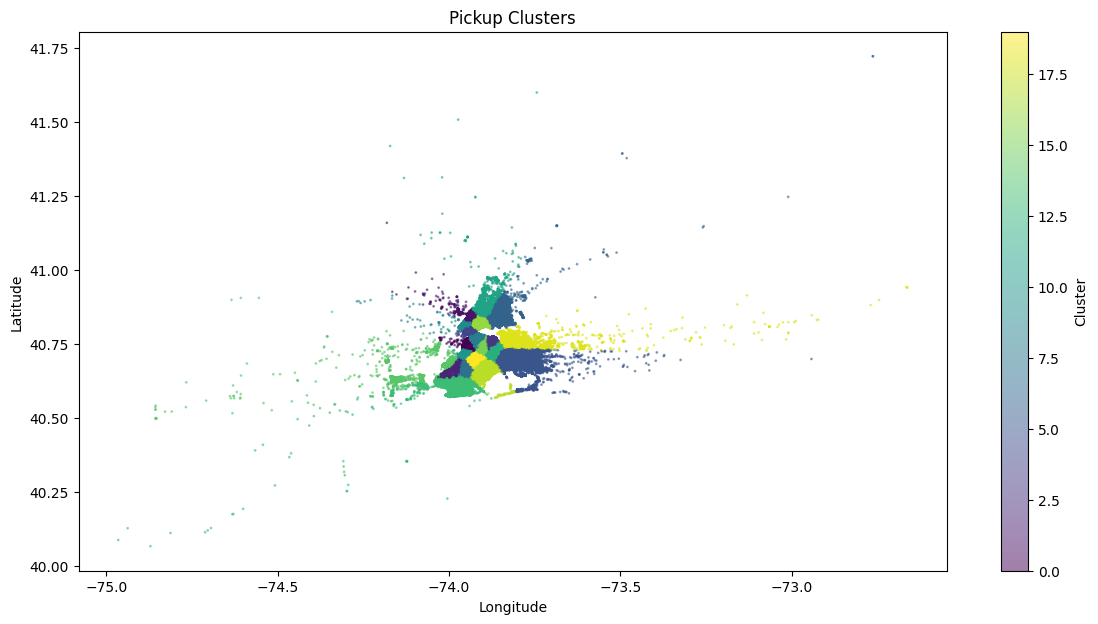

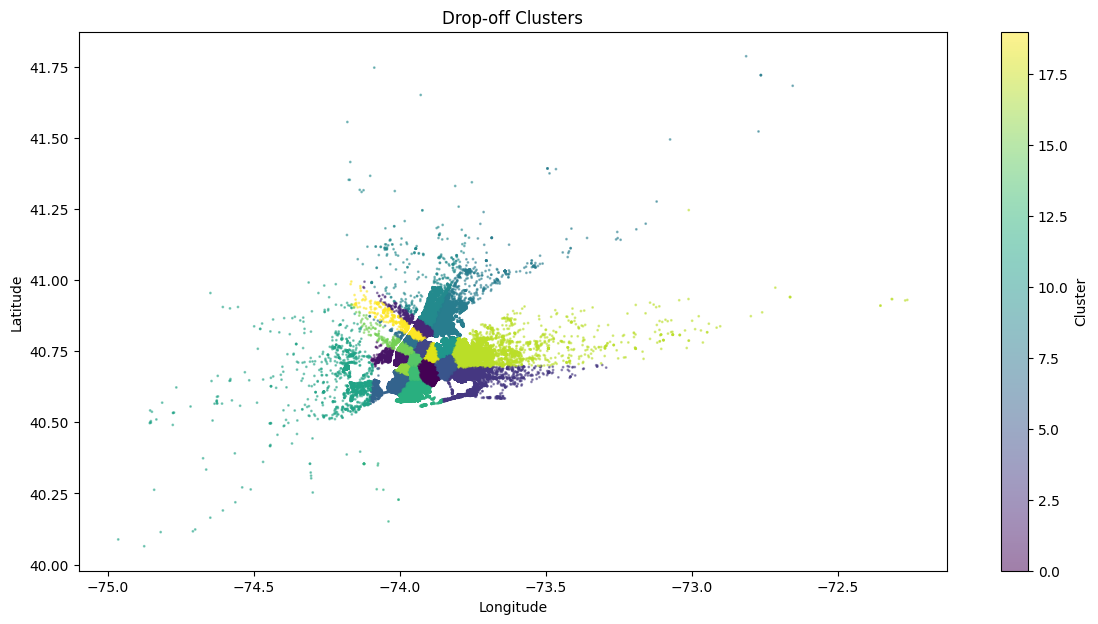

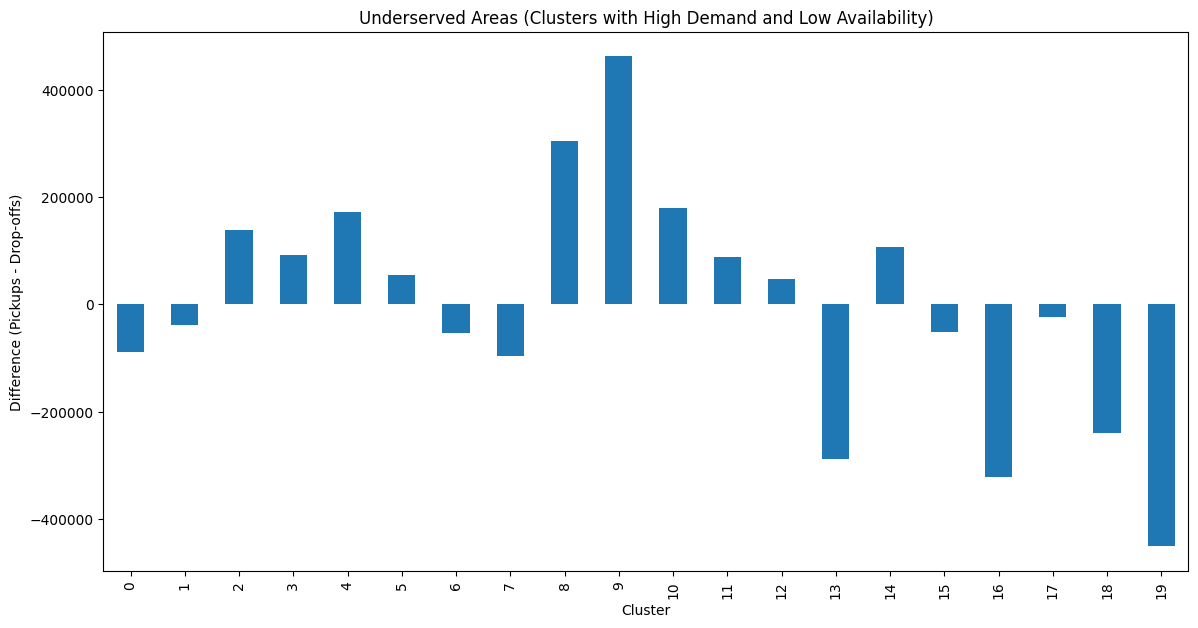

In [7]:
# Import necessary libraries
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import logging

# Set the logging level to ERROR to suppress verbose logging
logging.getLogger('azureml.opendatasets').setLevel(logging.ERROR)

# Set the date range for Q1 2016
start_date = parser.parse('2016-01-01')
end_date = parser.parse('2016-03-31')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Filter out rows with invalid coordinates and create a copy to avoid SettingWithCopyWarning
nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['pickupLatitude'].between(40, 42)) & 
                        (nyc_tlc_df['pickupLongitude'].between(-75, -72)) &
                        (nyc_tlc_df['dropoffLatitude'].between(40, 42)) &
                        (nyc_tlc_df['dropoffLongitude'].between(-75, -72))].copy()

# Extract pickup and drop-off coordinates
pickup_coords = nyc_tlc_df[['pickupLatitude', 'pickupLongitude']]
dropoff_coords = nyc_tlc_df[['dropoffLatitude', 'dropoffLongitude']]

# Apply K-Means clustering
num_clusters = 20  # Adjust the number of clusters as needed
kmeans_pickup = KMeans(n_clusters=num_clusters, random_state=0).fit(pickup_coords)
kmeans_dropoff = KMeans(n_clusters=num_clusters, random_state=0).fit(dropoff_coords)

# Add cluster labels to the dataframe
nyc_tlc_df['pickup_cluster'] = kmeans_pickup.labels_
nyc_tlc_df['dropoff_cluster'] = kmeans_dropoff.labels_

# Analyze clusters to find underserved areas
pickup_cluster_counts = nyc_tlc_df['pickup_cluster'].value_counts().sort_index()
dropoff_cluster_counts = nyc_tlc_df['dropoff_cluster'].value_counts().sort_index()
underserved_areas = pickup_cluster_counts - dropoff_cluster_counts

# Plot clusters
plt.figure(figsize=(14, 7))
plt.scatter(nyc_tlc_df['pickupLongitude'], nyc_tlc_df['pickupLatitude'], c=nyc_tlc_df['pickup_cluster'], cmap='viridis', s=1, alpha=0.5)
plt.title('Pickup Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.savefig('pickup_clusters.png')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(nyc_tlc_df['dropoffLongitude'], nyc_tlc_df['dropoffLatitude'], c=nyc_tlc_df['dropoff_cluster'], cmap='viridis', s=1, alpha=0.5)
plt.title('Drop-off Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.savefig('dropoff_clusters.png')
plt.show()

# Plot underserved areas
plt.figure(figsize=(14, 7))
underserved_areas.plot(kind='bar')
plt.title('Underserved Areas (Clusters with High Demand and Low Availability)')
plt.xlabel('Cluster')
plt.ylabel('Difference (Pickups - Drop-offs)')
plt.savefig('underserved_areas.png')
plt.show()

# Save results to CSV files
nyc_tlc_df.to_csv('nyc_taxi_clusters.csv', index=False)
pickup_cluster_counts.to_csv('pickup_cluster_counts.csv', header=['Count'])
dropoff_cluster_counts.to_csv('dropoff_cluster_counts.csv', header=['Count'])
underserved_areas.to_csv('underserved_areas.csv', header=['Difference'])
